# License



MIT License

Copyright (c) 2018 Naoaki Okazaki

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [ ]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [ ]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## Visualize the dataset

5


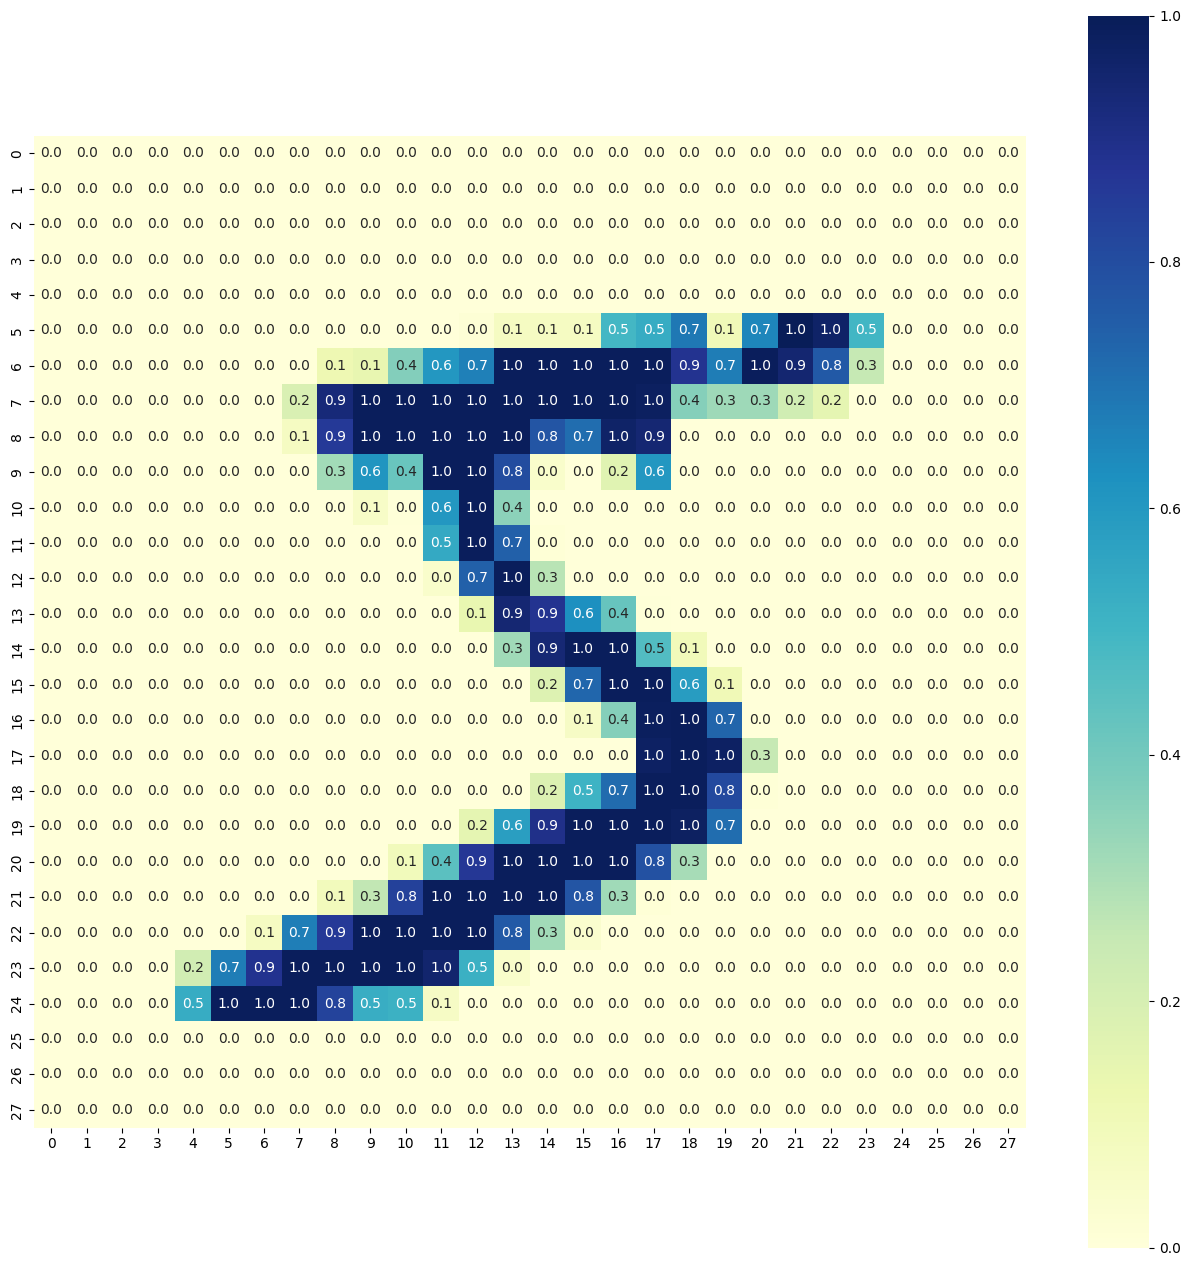

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 0

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## Install a library for plotting loss and accuracy values

In [ ]:
!pip install livelossplot

## Perceptron algorithm for single-layer neural network

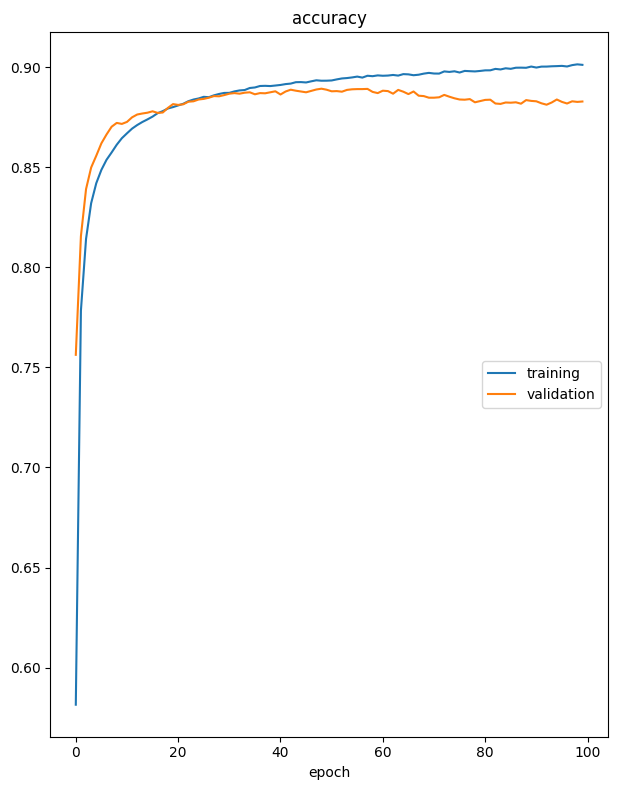

accuracy
	training         	 (min:    0.581, max:    0.901, cur:    0.901)
	validation       	 (min:    0.756, max:    0.889, cur:    0.883)
Accuracy: 0.8829 (test), 0.9012 (train)


In [ ]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

## Stochastic gradient descent for single-layer neural network

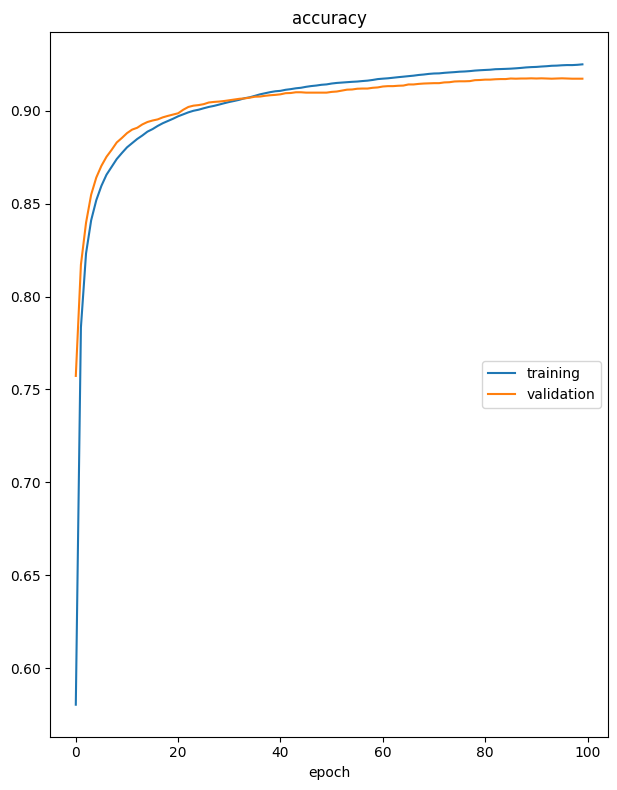

accuracy
	training         	 (min:    0.580, max:    0.925, cur:    0.925)
	validation       	 (min:    0.757, max:    0.917, cur:    0.917)
Accuracy: 0.9172 (test), 0.9249 (train)


In [ ]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    num_correct_train = 0

    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

## Training with pytorch

### Install pytorch

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

### Convert the numpy arrays into pytorch tensor

In [ ]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

### Single-layer neural network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

device = torch.device("cpu") # Uncomment this to run on CPU
#device = torch.device("cuda:0") # Uncomment this to run on GPU

def create_dataset_one(x, y):
    xt = torch.from_numpy(x).view(len(x), -1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset_one(data['train_x'], data['train_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for t in range(100):
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        # Compute the loss value.
        loss = loss_fn(y_pred, y)

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


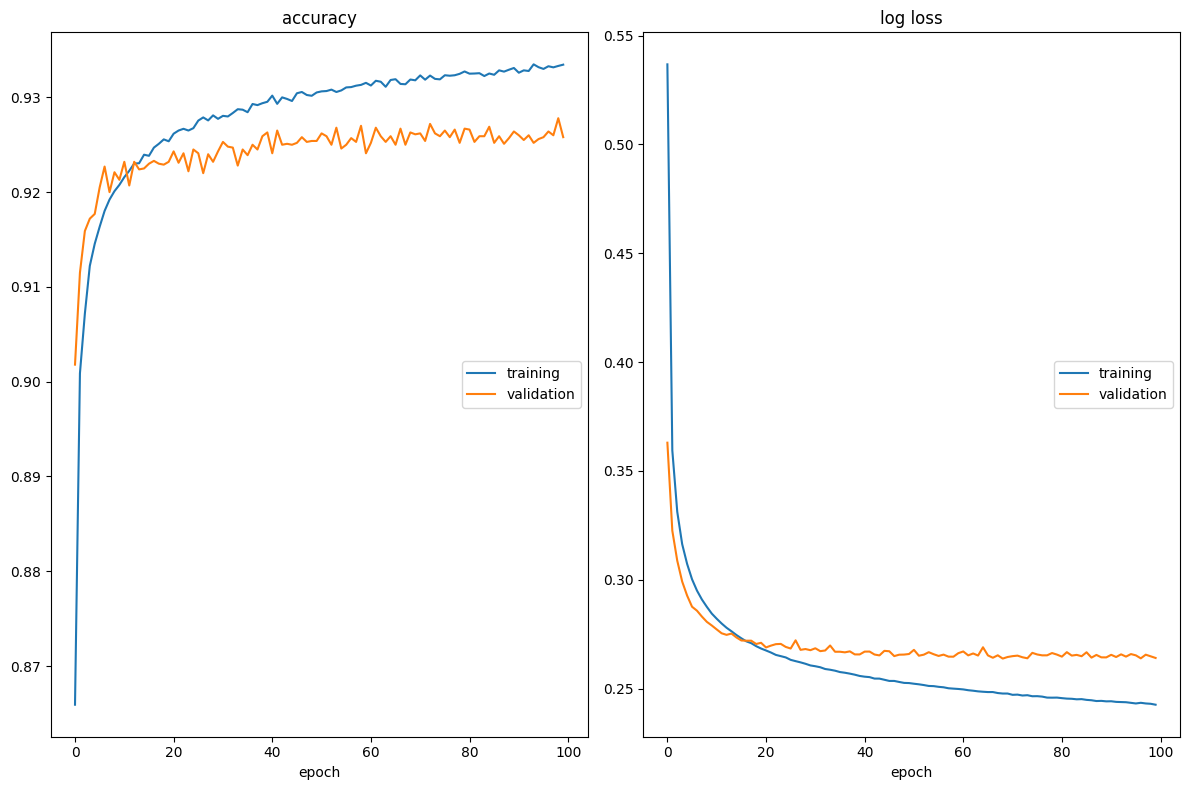

accuracy
	training         	 (min:    0.866, max:    0.933, cur:    0.933)
	validation       	 (min:    0.902, max:    0.928, cur:    0.926)
log loss
	training         	 (min:    0.243, max:    0.537, cur:    0.243)
	validation       	 (min:    0.264, max:    0.363, cur:    0.264)
Accuracy: 0.9258 (test), 0.9335 (train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset_one(data['train_x'], data['train_y'])
test_set = create_dataset_one(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

### Three-layer neural network

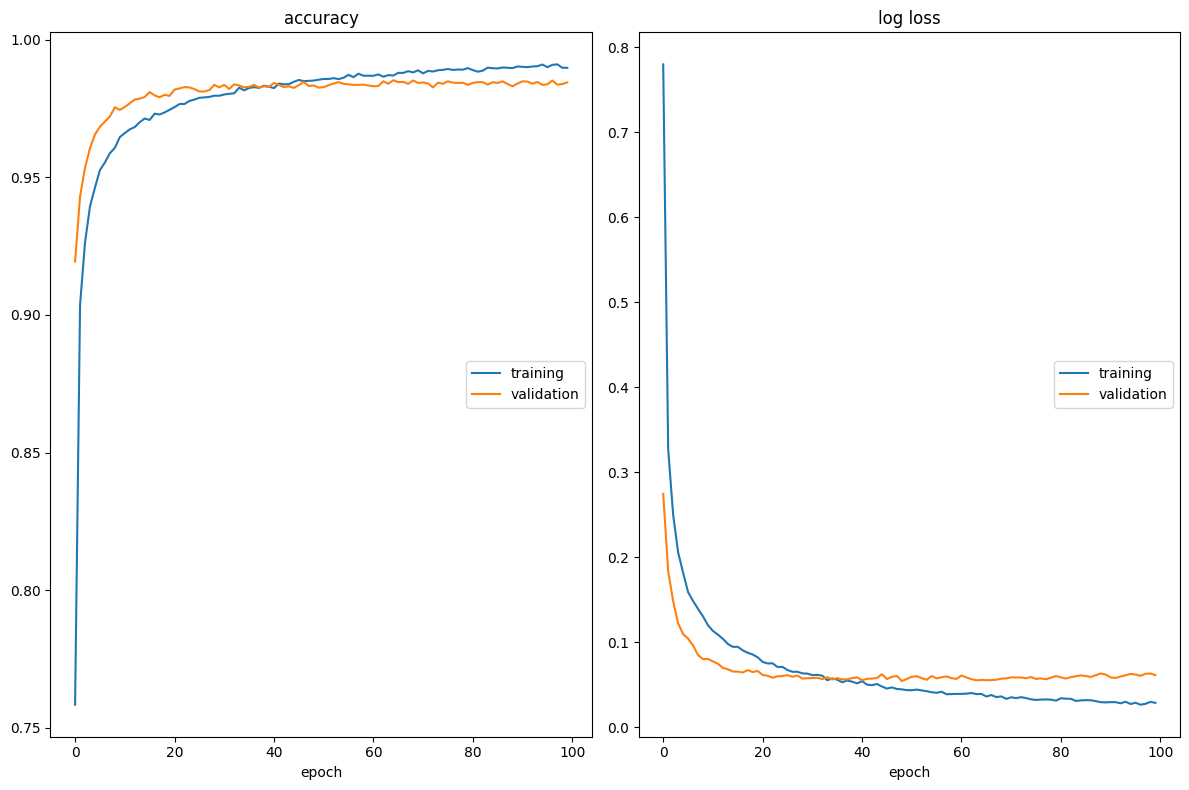

accuracy
	training         	 (min:    0.758, max:    0.991, cur:    0.990)
	validation       	 (min:    0.919, max:    0.985, cur:    0.985)
log loss
	training         	 (min:    0.027, max:    0.780, cur:    0.029)
	validation       	 (min:    0.054, max:    0.275, cur:    0.061)
Accuracy: 0.9845 (test), 0.9898 (train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

### Convolutional Neural Network (CNN)

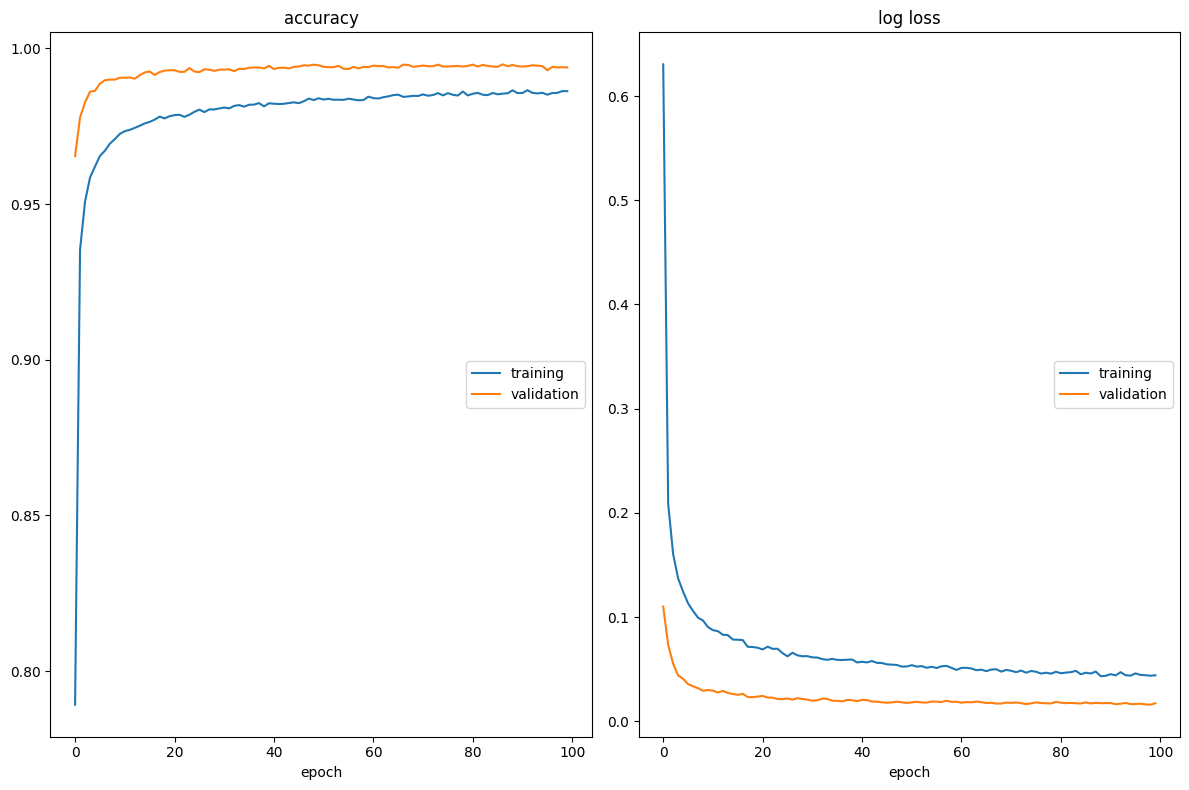

accuracy
	training         	 (min:    0.789, max:    0.987, cur:    0.986)
	validation       	 (min:    0.965, max:    0.995, cur:    0.994)
log loss
	training         	 (min:    0.043, max:    0.631, cur:    0.044)
	validation       	 (min:    0.016, max:    0.110, cur:    0.017)
Accuracy: 0.9939 (test), 0.9863 (train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'],flatten=False)
test_set = create_dataset(data['test_x'], data['test_y'],flatten=False)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))